# Denoising Diffusion Probabilistic Models (DDPM)

## Forward Process

$$ q(x_{t}|x_{t-1}) = \mathcal{N}(x_{t}, \sqrt{1-\beta_t}x_{t-1}, \beta_t I)$$

where :
- $ \mathcal{N} $       : Normal Distribution
- $ x_{t} $             : Output
- $ \sqrt{1-\beta_t} $  : Mean
- $  \beta_t I $        : Variance
## Reverse Process

$$ p(x_{t-1}|x_{t}) $$

$$ p_\theta(x_{t-1}|x_t) = \mathcal{N}(\mu_\theta(x_t,t),\Sigma_\theta(x_t,t)) $$

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms 

from tqdm.auto import tqdm

class Agrument:
    images = "./data"
    image_size = 256
    aug_scale = 0.05
    aug_angle = 15
    batch_size = 32
    epochs = 100
    lr = 0.0001
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
args = Agrument()
device = args.device

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset
As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set.

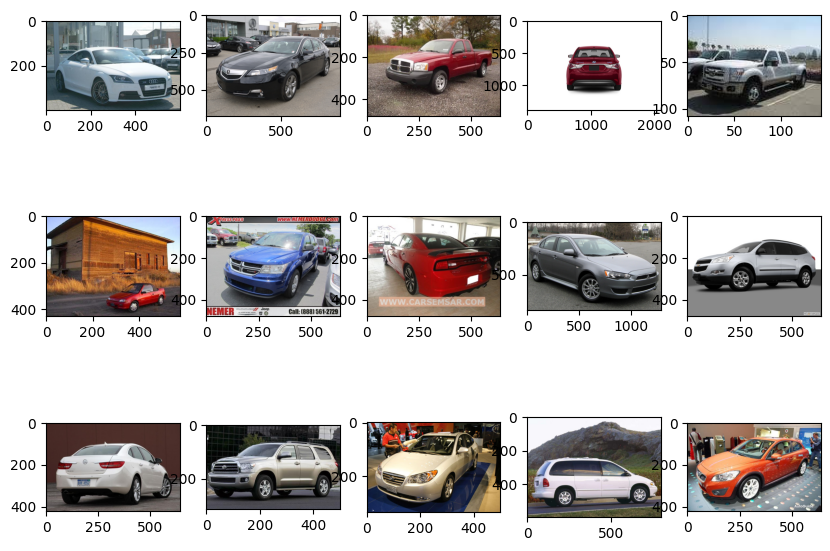

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(datset, num_samples=15, cols=5):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(10,10)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.StanfordCars(root="./data", download=False)
show_images(data)

###  Dataloder

In [3]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

image_size = args.image_size
batch_size = args.batch_size

data_transforms = [
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Scales data into [0,1] 
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
]
data_transform = transforms.Compose(data_transforms)
train = torchvision.datasets.StanfordCars(
    root="./data", download=False, transform=data_transform)
test = torchvision.datasets.StanfordCars(
    root="./data", download=False,  transform=data_transform, split='test')

dataset = torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

In [4]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
for image, label in dataloader:
    break

image.shape, label.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

## Building the Diffusion Model
1. Forward Process : Noise Scheduler
2. Backward Process : U-Net
3. Loss

where $\alpha_t = 1-\beta_t$

$$ \alpha_t =\prod_{i=0}^{t}\alpha_t $$

### Noise Scheduler
<img src="figures/linear_cosine.png" title="GAN Framework" style="width: 640px;" />

In [6]:
import torch.nn.functional as F
import math

def linear_beta_schedule(timesteps):
    """
    linear schedule, proposed in original ddpm paper
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001 
    beta_end = scale * 0.02 
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alpha_hat = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alpha_hat = alpha_hat / alpha_hat[0]
    betas = 1 - (alpha_hat[1:] / alpha_hat[:-1])
    return torch.clip(betas, 0, 0.999)

def sigmoid_beta_schedule(timesteps, start = -3, end = 3, tau = 1, clamp_min = 1e-5):
    """
    sigmoid schedule
    proposed in https://arxiv.org/abs/2212.11972 - Figure 8
    better for images > 64x64, when used during training
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype = torch.float64) / timesteps
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    alpha_hat = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (v_end - v_start)
    alpha_hat = alpha_hat / alpha_hat[0]
    betas = 1 - (alpha_hat[1:] / alpha_hat[:-1])
    return torch.clip(betas, 0, 0.999)

In [7]:
# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T) 
alpha = (1. - betas) 
alpha_hat = torch.cumprod(alpha, axis=0) 

In [8]:
def sample_timesteps(noise_steps, n):
    return torch.randint(low=1, high=noise_steps, size=(n,))

def noise_images(x, t):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t].cpu())[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    noise = torch.randn_like(x) 
    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise #mean + variance

/tmp/ipykernel_848279/1597071865.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


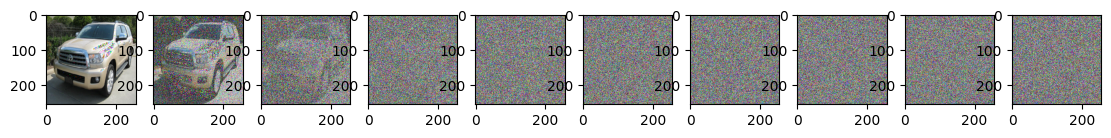

In [9]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = noise_images(image, t)
    show_tensor_image(img)

### UNet

In [10]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_dim, out_ch)
        self.conv1    = nn.Conv2d(in_ch, out_ch, 3)
        self.relu     = nn.ReLU()
        self.conv2    = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x, t):
        h = self.relu(self.conv1(x))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        return self.conv2(h)

class Encoder(nn.Module):
    def __init__(self, chs=(3, 64, 128, 256, 512, 1024), time_dim = 256):
        super().__init__()
        self.enc_blocks = nn.ModuleList(
            [Block(chs[i], chs[i+1], time_dim) for i in range(len(chs)-1)])
        # Max pooling layer
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x, t): 
        ftrs = []
        for block in self.enc_blocks:
            x = block(x, t)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64), time_dim = 256):
        super().__init__()
        self.chs         = chs
        # Up-convolution
        self.upconvs    = nn.ModuleList(
            [nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList(
            [Block(chs[i], chs[i+1], time_dim) for i in range(len(chs)-1)]) 
        
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs
    
    def forward(self, x, encoder_features, t):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x, t)
        return x

class UNet(nn.Module):
    def __init__(
        self, 
        enc_chs = (3,64,128,256,512,1024), 
        dec_chs = (1024, 512, 256, 128, 64), 
        num_classes = 3, 
        retain_dim = True, 
        out_sz = (256,256),
        time_dim = 256
    ):
        super().__init__()
        self.time_dim    = time_dim
        self.encoder     = Encoder(enc_chs, self.time_dim)
        self.decoder     = Decoder(dec_chs, self.time_dim)
        self.head        = nn.Conv2d(dec_chs[-1], num_classes, 1)#in_channels, out_channels, kernel_size
        self.retain_dim  = retain_dim
        self.out_sz      = out_sz   

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2).float() / channels)
        ).to(device)
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t_ = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t_, self.time_dim)

        enc_ftrs = self.encoder(x, t)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:], t) #1024, [512, 256, 128, 64]
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

In [11]:
model = UNet().to(device)
print("Num params:", sum(p.numel() for p in model.parameters()))

Num params: 31788483


## Loss

$$ L_t^\text{simple} = \mathbb{E}_{t \sim [1, T], \mathbf{x}_0, \boldsymbol{\epsilon}_t} \Big[\|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)\|^2 \Big] $$

$$ L_t^\text{simple} = \mathbb{E}_{t \sim [1, T], \mathbf{x}_0, \boldsymbol{\epsilon}_t} \Big[\|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t, t)\|^2 \Big] $$


$$ L_\text{simple} = L_t^\text{simple} + C $$

<img src="figures/DDPM-algo.png" title="GAN Framework" style="width: 640px;" />

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation 
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [13]:
# Pre-calculate different terms for closed form
alpha_hat_prev = F.pad(alpha_hat[:-1], (1, 0), value=1.0)
sqrt_recip_alpha = torch.sqrt(1.0 / alpha)
sqrt_alpha_hat = torch.sqrt(alpha_hat)
sqrt_one_minus_alpha_hat = torch.sqrt(1. - alpha_hat)
posterior_variance = betas * (1. - alpha_hat_prev) / (1. - alpha_hat)


def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def noise_images(x, t):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t].cpu())[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    noise = torch.randn_like(x) 
    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise #mean + variance

@torch.no_grad()
def sample_timestep(x, t, sqrt_one_minus_alpha_hat):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alpha_hat = get_index_from_list(
        sqrt_one_minus_alpha_hat, t, x.shape
    )
    sqrt_recip_alpha_t = get_index_from_list(sqrt_recip_alpha, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alpha_t * (
        x - betas_t * model(x.to(device), t.to(device)) / sqrt_one_minus_alpha_hat
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(img_size = 256, sqrt_one_minus_alpha_hat=sqrt_one_minus_alpha_hat):
    # Sample noise
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, sqrt_one_minus_alpha_hat)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

## Training 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | step 000 Loss: 0.9563819766044617 


/tmp/ipykernel_848279/1427126178.py:39: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


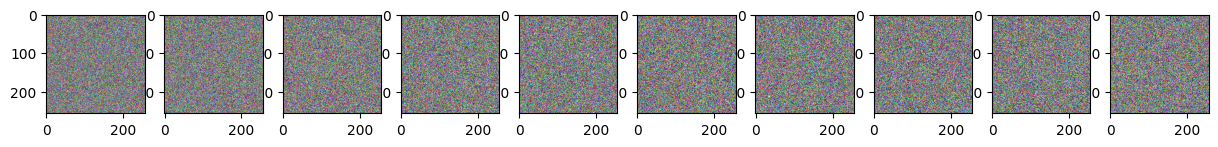

  1%|          | 1/100 [01:50<3:02:33, 110.64s/it]

In [ ]:
for epoch in tqdm(range(epochs)):
    for step, batch in enumerate(dataloader):
        image, label = batch
        optimizer.zero_grad()
        
        # t = torch.randint(0, T, (batch_size,), device=device).type(torch.int64)
        t = sample_timesteps(T, batch_size) #.to(device)
        x_noisy, noise = noise_images(image, t)
        x_noisy = x_noisy.type(torch.float)
        
        t = t.to(device)
        x_noisy = x_noisy.to(device)
        noise = noise.to(device)
        
        noise_pred = model(x_noisy, t)
        loss = F.l1_loss(noise, noise_pred)
        
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            # sample_plot_image()
            img_size = 256
            img = torch.randn((1, 3, img_size, img_size)) #, device=device)
            plt.figure(figsize=(15,15))
            plt.axis('off')
            num_images = 10
            stepsize = int(T/num_images)

            for i in range(0,T)[::-1]:
                t = torch.full((1,), i) #, device=device, dtype=torch.long)
                #img = sample_timestep(img, t, sqrt_one_minus_alpha_hat)
                img, noise = noise_images(img, t)
                # Edit: This is to maintain the natural range of the distribution
                img = torch.clamp(img, -1.0, 1.0)
                if i % stepsize == 0:
                    plt.subplot(1, num_images, int(i/stepsize)+1)
                    show_tensor_image(img.detach().cpu())
            plt.show()   
                 
        torch.save(model.state_dict(), os.path.join("save_model", f"diffusion_unet.pt"))